In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import copy
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload
from tqdm.notebook import tqdm
from typing import List, Dict, Tuple

import celeri

plt.rcParams[
    "text.usetex"
] = False  # Plotting the global model is much much faster with tex fonts turned off

# Read in data files, create storage dictionaries, and do basic processing

In [3]:
# Western North America example
command_file_name = "../data/command/western_north_america_command.json"
# Japan model
# command_file_name = "../data/command/japan_command.json"

In [4]:
command = celeri.get_command(command_file_name)
celeri.create_output_folder(command)
logger = celeri.get_logger(command)
segment, block, meshes, station, mogi, sar = celeri.read_data(command)
station = celeri.process_station(station, command)
segment = celeri.process_segment(segment, command, meshes)
# segment = celeri.snap_segments(segment, meshes)
sar = celeri.process_sar(sar, command)
closure, block = celeri.assign_block_labels(segment, station, block, mogi, sar)
assembly = addict.Dict()
operators = addict.Dict()
operators.meshes = [addict.Dict()] * len(meshes)
assembly = celeri.merge_geodetic_data(
    assembly, station, sar
)  # Not sure this works correctly

2024-07-10 18:12:39.883 | INFO     | celeri.celeri:get_logger:5438 - Read: ../data/command/western_north_america_command.json
2024-07-10 18:12:39.884 | INFO     | celeri.celeri:get_logger:5439 - RUN_NAME: 2024-07-10-18-12-39
2024-07-10 18:12:39.884 | INFO     | celeri.celeri:get_logger:5440 - Write log file: ../runs/2024-07-10-18-12-39/2024-07-10-18-12-39.log
2024-07-10 18:12:39.885 | INFO     | celeri.celeri:read_data:231 - Reading data files
2024-07-10 18:12:39.890 | SUCCESS  | celeri.celeri:read_data:235 - Read: ../data/segment/western_north_america_segment.csv
2024-07-10 18:12:39.892 | SUCCESS  | celeri.celeri:read_data:240 - Read: ../data/block/western_north_america_block.csv
2024-07-10 18:12:39.893 | SUCCESS  | celeri.celeri:read_data:247 - Read: ../data/mesh/western_north_america_mesh_parameters.json

2024-07-10 18:12:40.010 | SUCCESS  | celeri.celeri:read_data:397 - Read: ../data/mesh/cascadia.msh
2024-07-10 18:12:40.014 | SUCCESS  | celeri.celeri:read_data:433 - Read: ../data/

# Get elastic operators and TDE smoothing operators

In [5]:
# Get all elastic operators for segments and TDEs
celeri.get_elastic_operators(operators, meshes, segment, station, command)

# Get TDE smoothing operators
celeri.get_all_mesh_smoothing_matrices(meshes, operators)

2024-07-10 18:12:41.979 | INFO     | celeri.celeri:get_elastic_operators:1587 - Using precomputed elastic operators


# Calculate non-elastic operators

In [6]:
operators.rotation_to_velocities = celeri.get_rotation_to_velocities_partials(
    station, len(block)
)
operators.global_float_block_rotation = celeri.get_global_float_block_rotation_partials(
    station
)
assembly, operators.block_motion_constraints = celeri.get_block_motion_constraints(
    assembly, block, command
)
assembly, operators.slip_rate_constraints = celeri.get_slip_rate_constraints(
    assembly, segment, block, command
)
operators.rotation_to_slip_rate = celeri.get_rotation_to_slip_rate_partials(
    segment, block
)

(
    operators.block_strain_rate_to_velocities,
    strain_rate_block_index,
) = celeri.get_block_strain_rate_to_velocities_partials(block, station, segment)
operators.mogi_to_velocities = celeri.get_mogi_to_velocities_partials(
    mogi, station, command
)
celeri.get_tde_slip_rate_constraints(meshes, operators)
celeri.get_tde_coupling_constraints(meshes, segment, block, operators)

2024-07-10 18:12:44.578 | INFO     | celeri.celeri:get_slip_rate_constraints:2835 - Found 1 slip rate constraints
2024-07-10 18:12:44.582 | INFO     | celeri.celeri:get_slip_rate_constraints:2838 - Strike-slip rate constraint on cfm_san_andreas_mojave_extruded_trace_part1_sa: rate = -50.00 (mm/yr), 1-sigma uncertainty = +/-1.00 (mm/yr)
[0.016553245653249355, 179.99371613865122]
[0.016553245653249355, 179.99371613865122]


# Plot input data

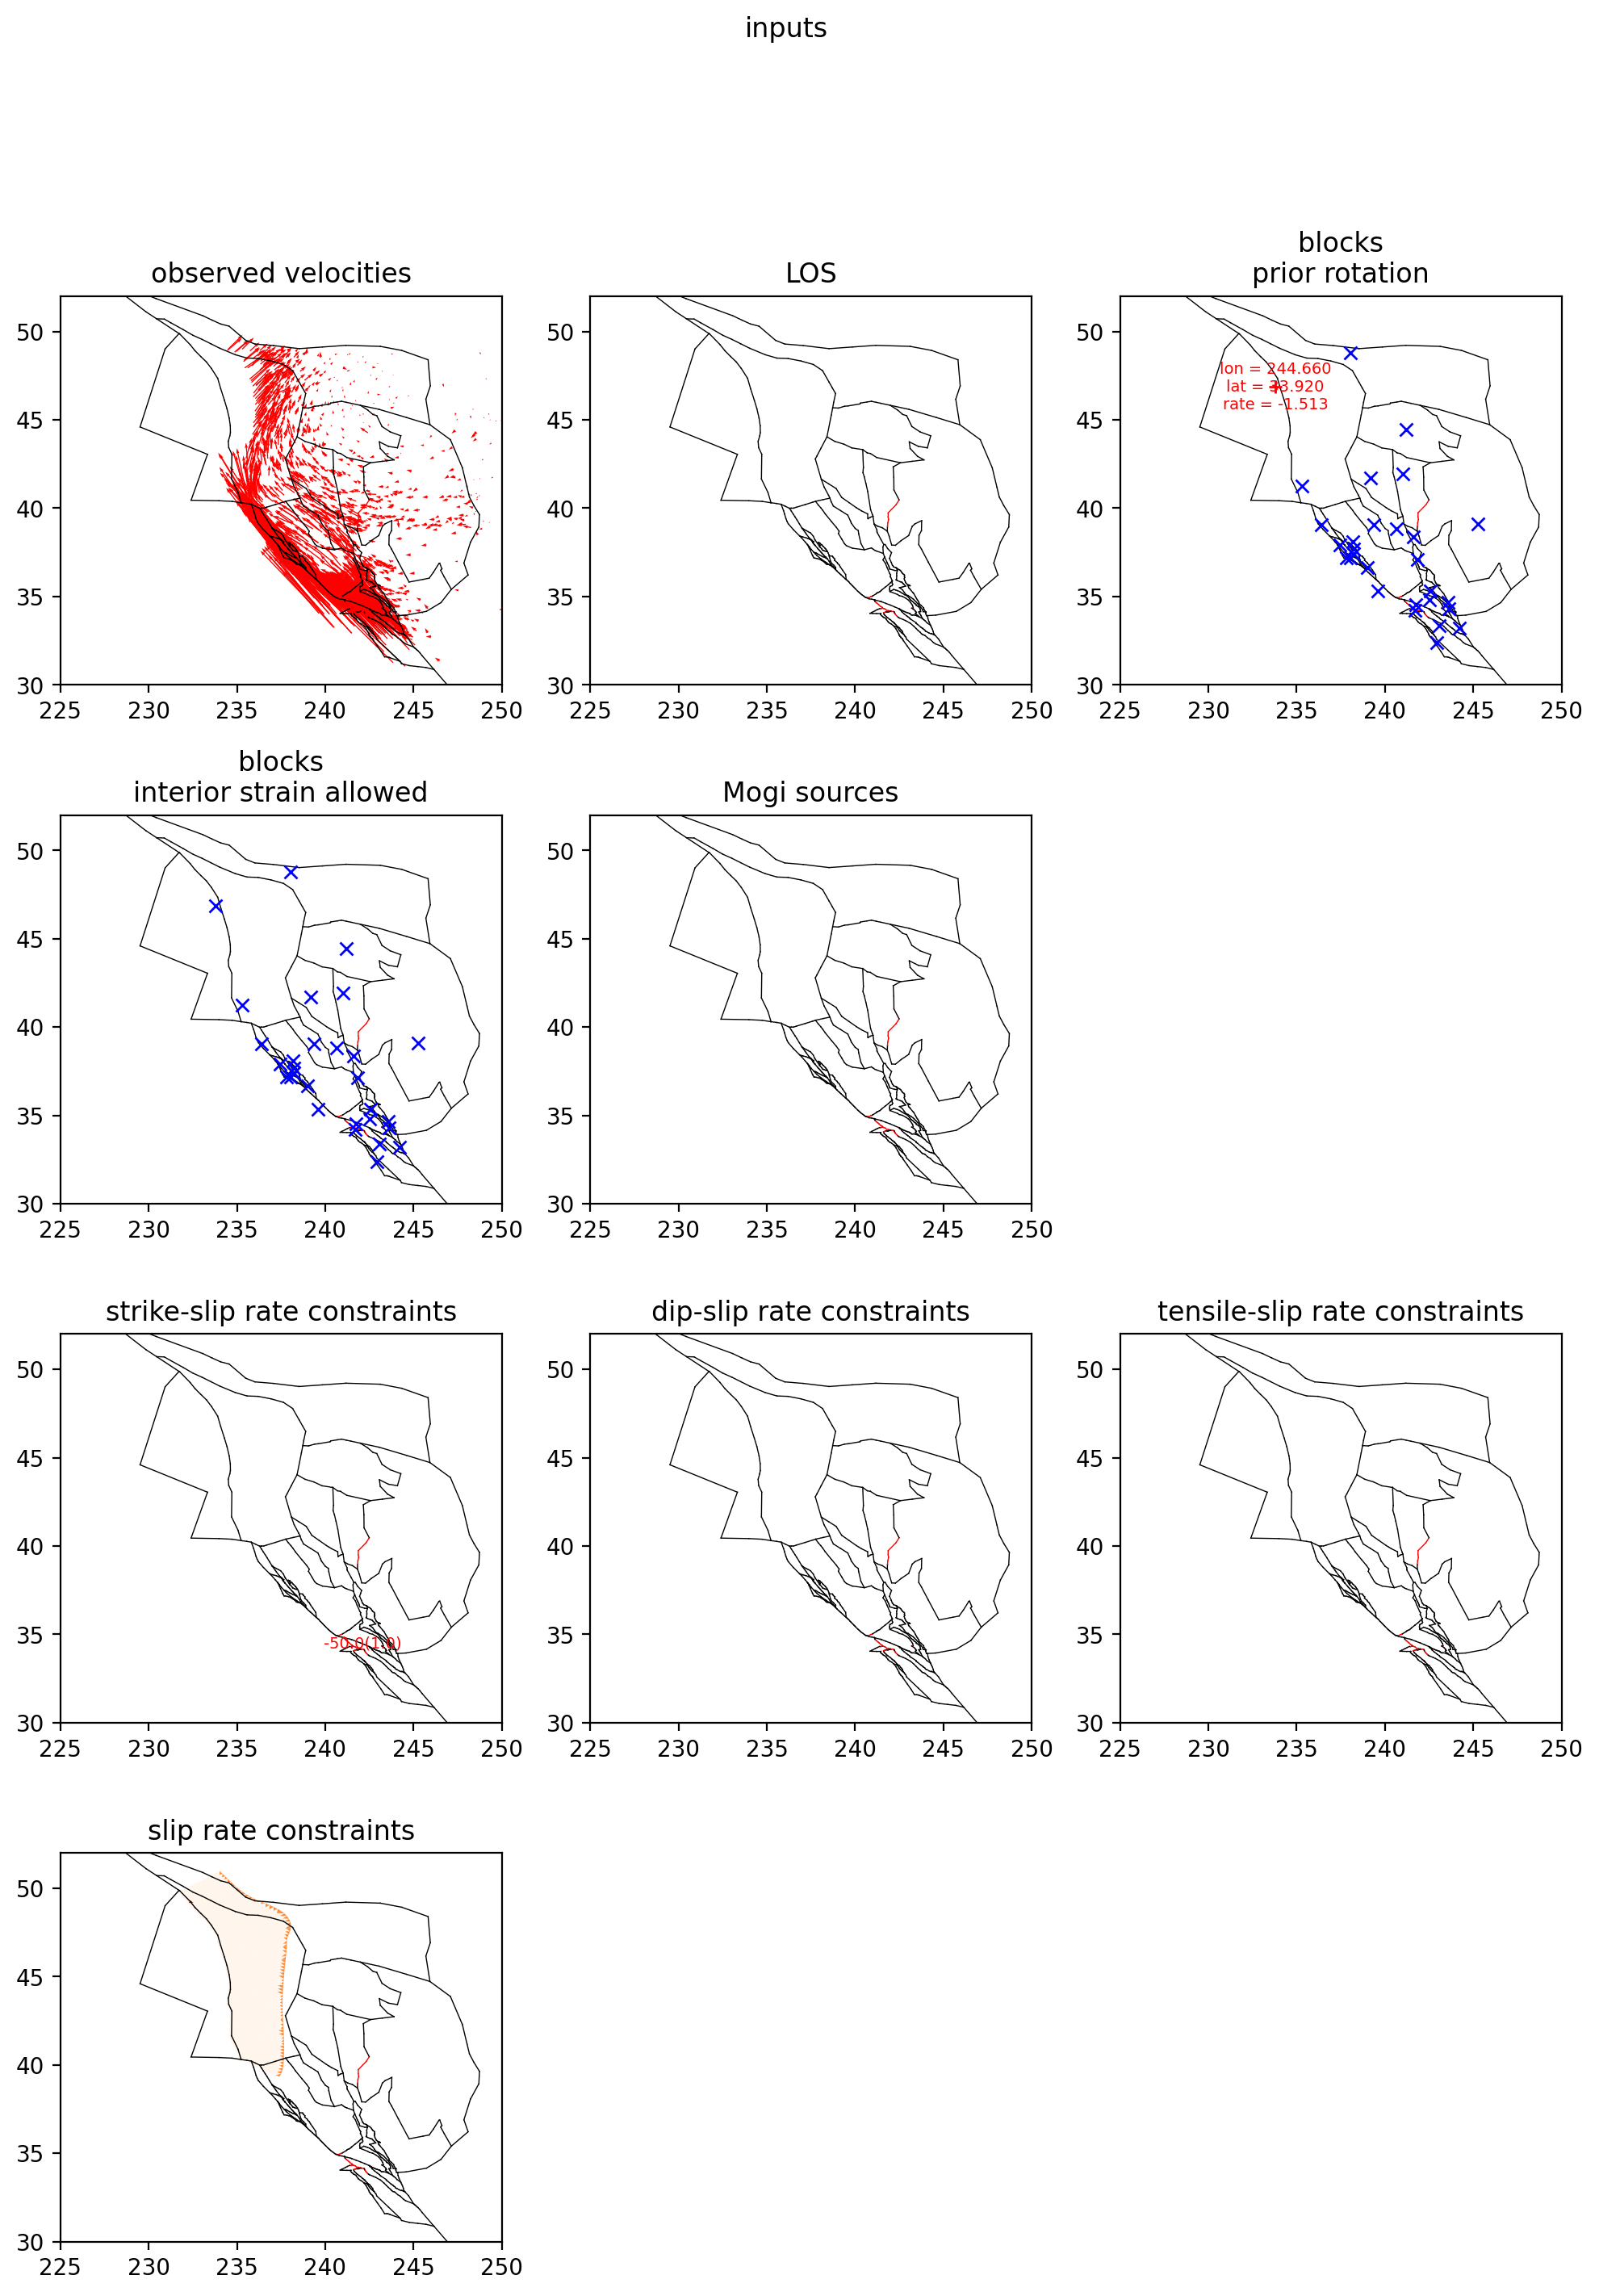

2024-07-10 18:13:03.942 | SUCCESS  | celeri.celeri:plot_input_summary:5065 - Wrote figures../runs/2024-07-10-18-12-39/plot_input_summary.(pdf, png)


<Figure size 640x480 with 0 Axes>

In [7]:
celeri.plot_input_summary(
    command,
    segment,
    station,
    block,
    meshes,
    mogi,
    sar,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=1e2,
)

# Sketching out the assembly of the block model system

$$
\begin{bmatrix}
    \mathrm{geodetic \; velocities} \\
    \mathrm{plate \; rotation \; constraints} \\
    \mathrm{slip \; rate \; constraints} \\
    \mathrm{TDE \; smoothing \; pseudodata = 0} \\
    \mathrm{TDE \; rate \; constraints} \\
    \mathrm{TDE \; coupling \; constraints = 0} \\
    \mathrm{InSAR \; LOS \; changes} 
\end{bmatrix}
=
\begin{bmatrix}
    \mathrm{(rotations-elastic \; segments) \; to \; velocities} & \mathrm{TDEs \; to \; velocities} & \mathrm{block \; strain \; rate \; to \; velocities} & \mathrm{Mogi \; to \; velocities}\\
    \mathrm{identities}                                          & 0                                   & 0 \\
    \mathrm{plate \; rotations \; to \; slip \; rates}           & 0                                   & 0 \\
    0                                                            & \mathrm{TDE \; smoothing \; matrix} & 0 \\
    0                                                            & \mathrm{identities}                 & 0 \\
    -\phi(\mathrm{plate \; rotations \; to \; TDE \; slip \; rates)}    & \mathrm{identities}                & 0 \\
    \mathrm{(rotations-elastic \; segments) \; to \; LOS}        & \mathrm{TDEs \; to \; LOS}          & \mathrm{block \; strain \; rate \; to \; velocities}
\end{bmatrix}
\begin{bmatrix}
    \mathrm{plate \; rotation \; rates} \\
    \mathrm{TDE \; slip \; rates} \\
    \mathrm{block \; strain \; rates} \\
    \mathrm{Mogi \; rates}
\end{bmatrix}
$$

# Estimate block model parameters (dense)

In [8]:
index, estimation = celeri.assemble_and_solve_dense(
    command, assembly, operators, station, block, meshes
)
celeri.post_process_estimation(estimation, operators, station, index)
celeri.write_output(command, estimation, station, segment, block, meshes)

# Plot model summary

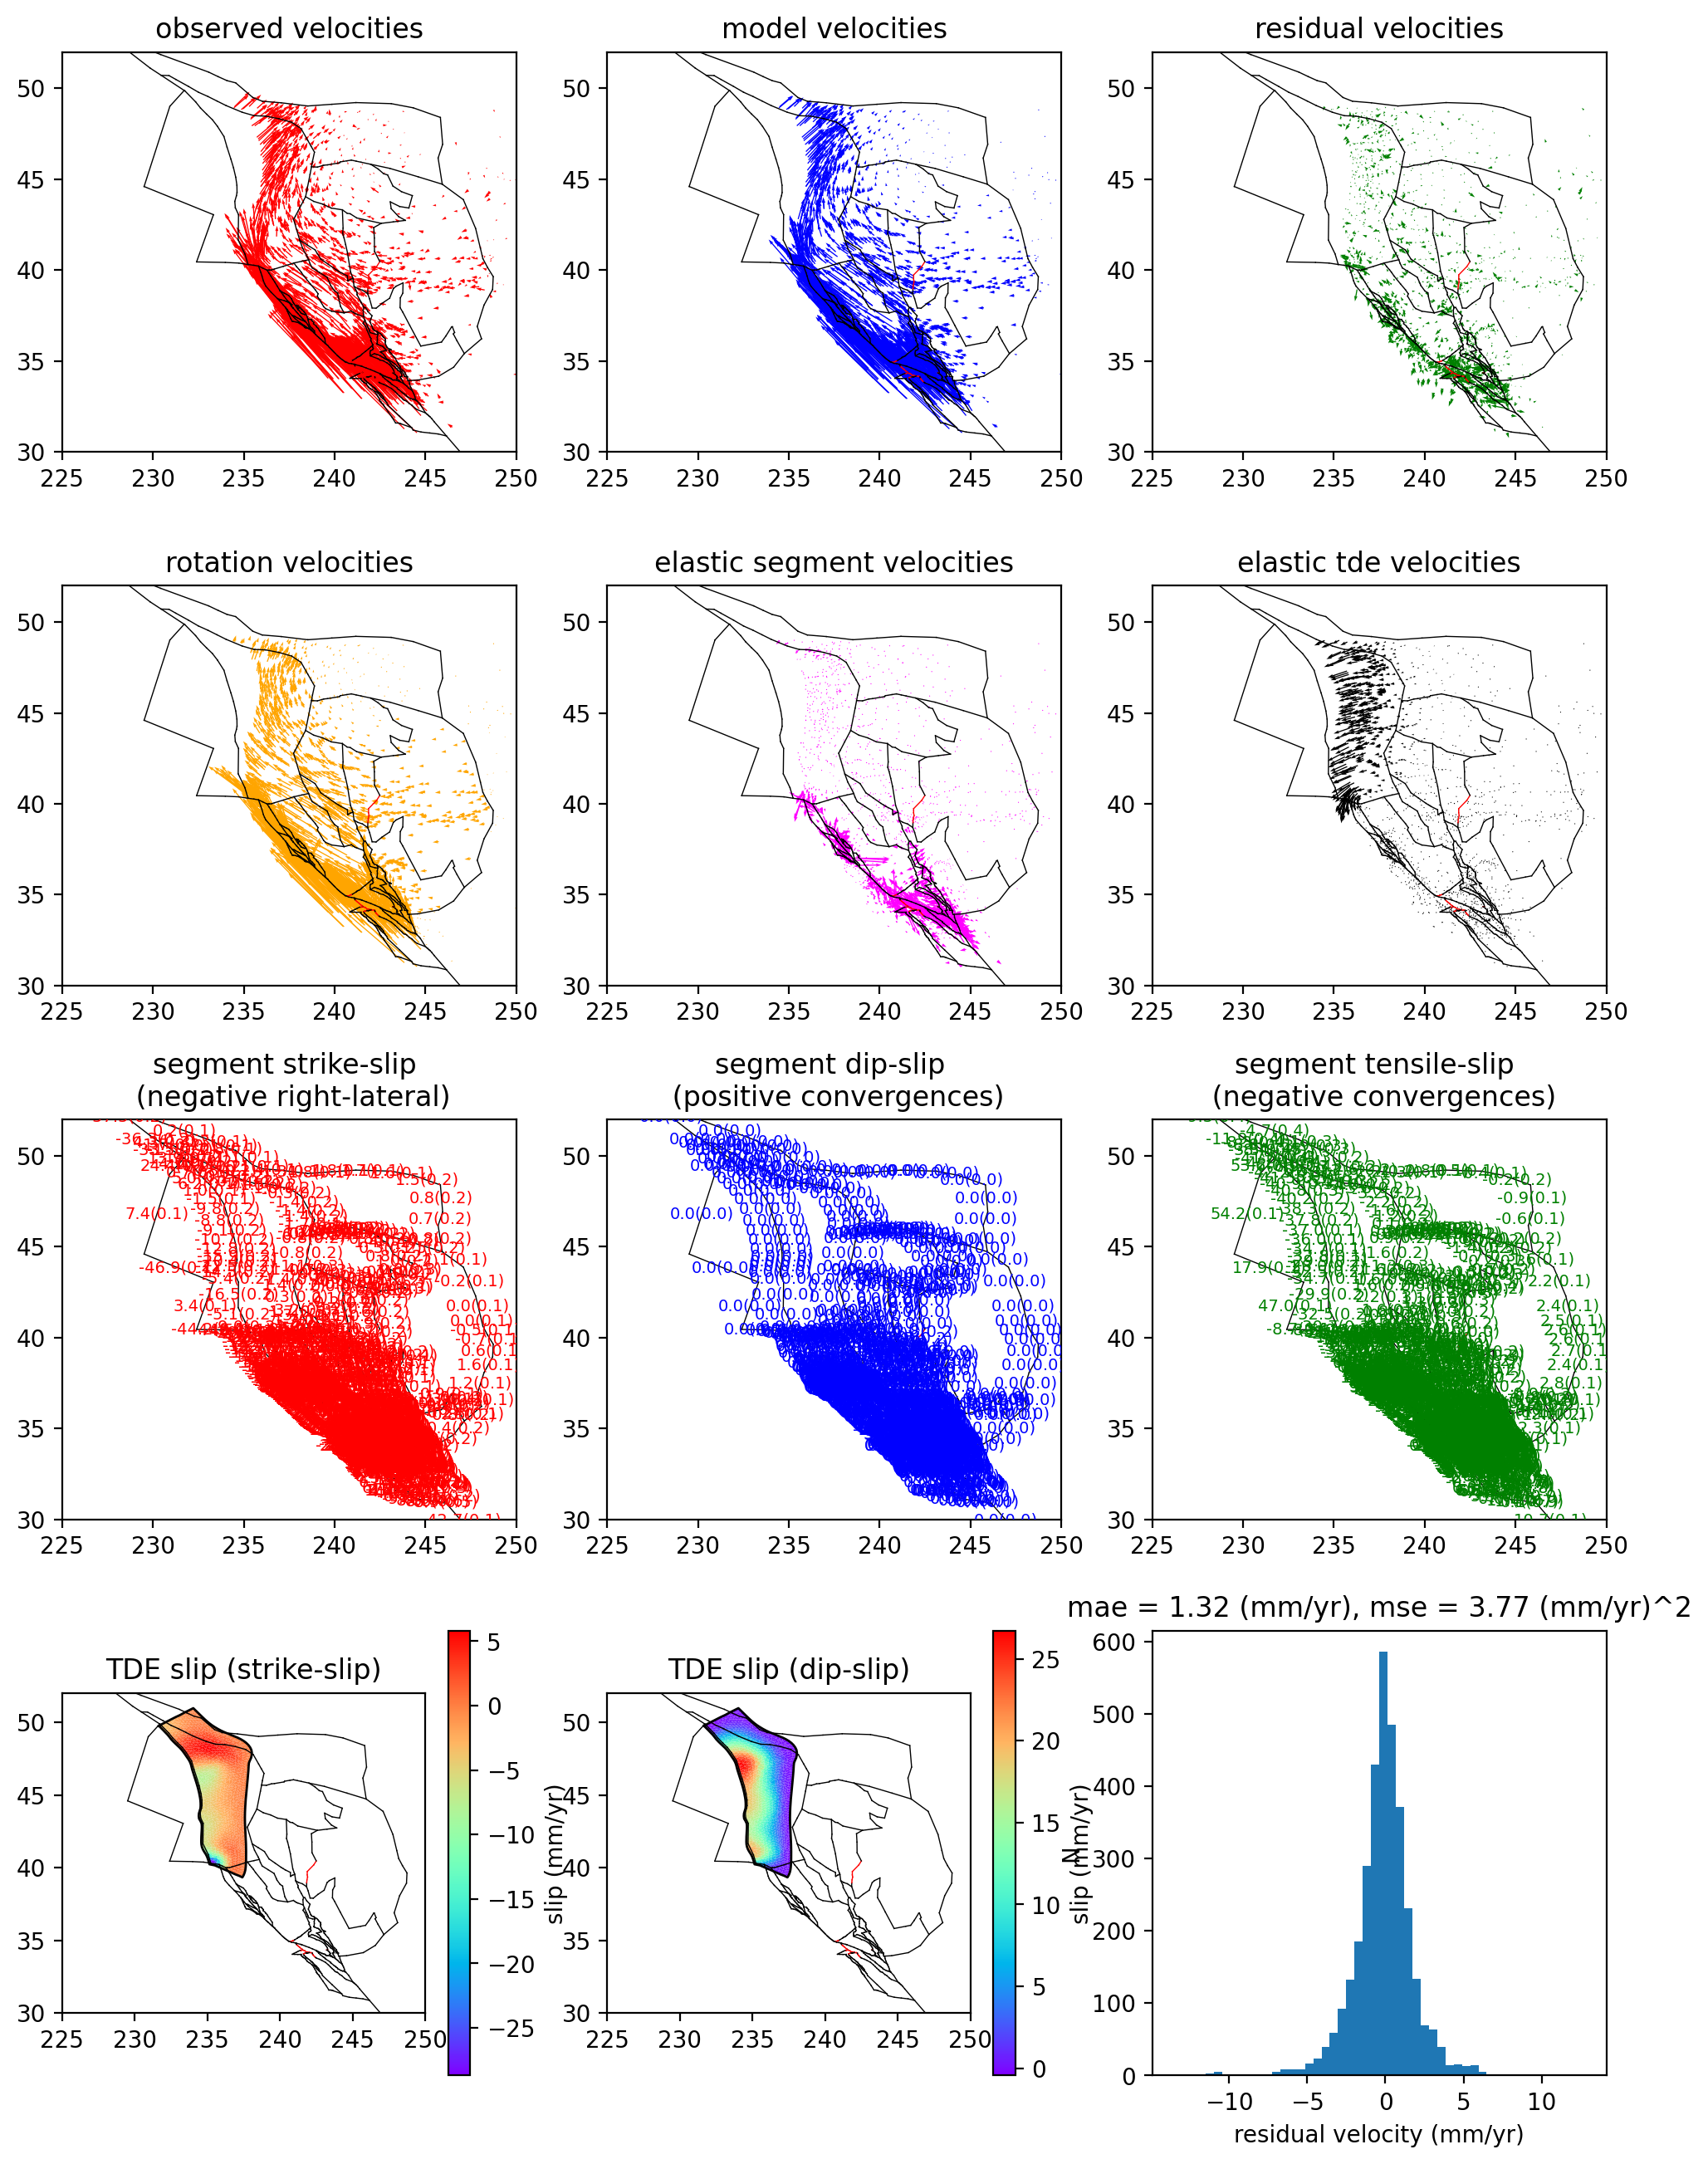

2024-07-10 18:13:13.200 | SUCCESS  | celeri.celeri:plot_estimation_summary:5405 - Wrote figures../runs/2024-07-10-18-12-39/plot_estimation_summary.(pdf, png)


<Figure size 640x480 with 0 Axes>

In [9]:
celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=1e2,
)

### Testing triangular coupling calculations

In [10]:
# Calculate partials
tricoup = celeri.get_rotation_to_tri_slip_rate_partials(meshes[0], 0, segment, block)
# Do the projection of block motions
trislip = tricoup @ estimation.state_vector[0 : 3 * index.n_blocks]
# Isolate components
tristrike = trislip[0::3]
tridip = trislip[1::3]
tritens = trislip[2::3]
# Identify segments closest to each element
csi = np.unique(meshes[0].closest_segment_idx)

[0.016553245653249355, 179.99371613865122]
[0.016553245653249355, 179.99371613865122]


#### Visualize projected slip rates

463    156.516774
464    168.686250
465    167.386231
466    167.999485
467    170.525301
468    174.034996
469    179.368284
470      7.504482
471     11.707677
472    176.544155
473    161.231759
474      0.541169
475    159.831338
718    167.091455
758    147.338930
759    152.281303
760    146.635540
761    145.214217
762    152.675123
Name: azimuth, dtype: float64


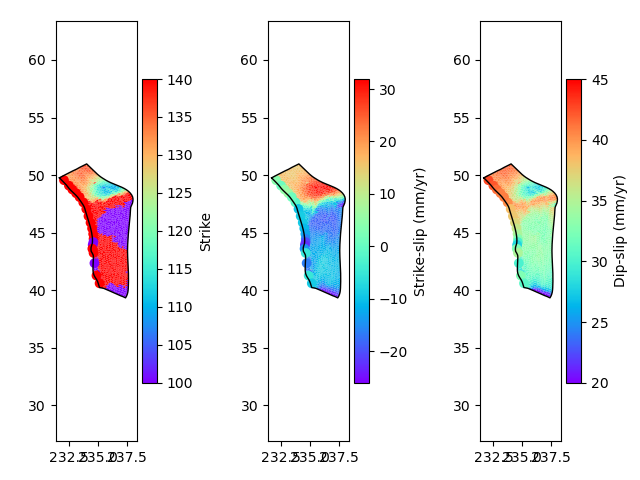

In [11]:
# plt.close('all')
import matplotlib
%matplotlib widget

import pyproj
GEOID = pyproj.Geod(ellps="WGS84")
segment_azimuth = np.zeros_like(segment.lon1)
for i in range(len(segment.lon1)):
    segment_azimuth[i], _, _ = GEOID.inv(segment.lon1[i], segment.lat1[i], segment.lon2[i], segment.lat2[i])
rhrstrike = segment_azimuth + 180

seg_flip = np.zeros_like(segment.lon1)
seg_flip[segment.lat2 < segment.lat1] = -1000
import matplotlib.colors as colors
fig1, ax = plt.subplots(1, 3)
i = 0
fill_value0 = meshes[i].strike
# fill_value0[fill_value0 > 180] -= 180
# fill_value_range0 = [np.min(fill_value0), np.max(fill_value0)]
fill_value_range0 = [100, 140]
x_coords = meshes[i].meshio_object.points[:, 0]
y_coords = meshes[i].meshio_object.points[:, 1]
vertex_array = np.asarray(meshes[i].verts)
xy = np.c_[x_coords, y_coords]
verts = xy[vertex_array]
pc0 = matplotlib.collections.PolyCollection(
    verts, edgecolor="none", cmap="rainbow"
)
pc0.set_array(
    fill_value0
)
pc0.set_clim(fill_value_range0)
ax[0].add_collection(pc0)
ax[0].scatter(segment.mid_lon[csi], segment.mid_lat[csi], vmin=fill_value_range0[0], vmax=fill_value_range0[1], c=segment.azimuth[csi], cmap="rainbow")
plt.colorbar(pc0, label="Strike", ax=ax[0])
# Add mesh edge
x_edge = x_coords[meshes[i].ordered_edge_nodes[:, 0]]
y_edge = y_coords[meshes[i].ordered_edge_nodes[:, 0]]
x_edge = np.append(x_edge, x_coords[meshes[0].ordered_edge_nodes[0, 0]])
y_edge = np.append(y_edge, y_coords[meshes[0].ordered_edge_nodes[0, 0]])
ax[0].plot(x_edge, y_edge, color="black", linewidth=1)
ax[0].axis('equal')

fill_value1 = tristrike
fill_value_range1 = [np.min(fill_value1), np.max(fill_value1)]

pc1 = matplotlib.collections.PolyCollection(
    verts, edgecolor="none", cmap="rainbow"
)
pc1.set_array(
    fill_value1
)
pc1.set_clim(fill_value_range1)
ax[1].add_collection(pc1)
ax[1].scatter(segment.mid_lon[csi], segment.mid_lat[csi], vmin=fill_value_range1[0], vmax=fill_value_range1[1], c=estimation.strike_slip_rates[csi], cmap="rainbow")
plt.colorbar(pc1, label="Strike-slip (mm/yr)", ax=ax[1])
# Add mesh edge
ax[1].plot(x_edge, y_edge, color="black", linewidth=1)
ax[1].axis('equal')


fill_value2 = tridip
fill_value_range2 = [20, 45]
pc2 = matplotlib.collections.PolyCollection(
    verts, edgecolor="none", cmap="rainbow"
)
pc2.set_array(
    fill_value2
)

ax[2].add_collection(pc2)
pc2.set_clim(fill_value_range2)
ax[2].scatter(segment.mid_lon[csi], segment.mid_lat[csi], vmin=fill_value_range2[0], vmax=fill_value_range2[1], c=-estimation.tensile_slip_rates[csi], cmap="rainbow")
plt.colorbar(pc2, label="Dip-slip (mm/yr)", ax=ax[2])
# Add mesh edge
ax[2].plot(x_edge, y_edge, color="black", linewidth=1)
ax[2].axis('equal')

fig1.tight_layout()
# print(estimation.strike_slip_rates[csi])
# print(estimation.tensile_slip_rates[csi])
print(segment.azimuth[csi])


In [ ]:
names = ['0000000001', '0000000002']
int_list = [int(i) for i in names]